<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/1D-CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [543]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.io import wavfile
from scipy.signal import decimate

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [544]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [545]:
INPUT_LIB = '/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/hw-cnn-heartbeat-skeleton/data/heartbeat'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

### Load data

In [546]:
def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

In [547]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

### Load data

In [548]:
df = pd.read_csv(INPUT_LIB + '/input.csv')
df['time_series'] = df['file_name'].apply(load_wav_file, 
                                          path=INPUT_LIB + '/set_a/')    
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, 
                                            length=MAX_LEN) 

In [549]:
df.head()

,index,file_name,labels,time_series,len_series
0,0,artifact__201012172012.wav,0,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,1,artifact__201105040918.wav,0,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,2,artifact__201105041959.wav,0,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,3,artifact__201105051017.wav,0,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,4,artifact__201105060108.wav,0,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


### Split the data

In [550]:
x_data = np.stack(df['time_series'].values, axis=0)
y_data = pd.get_dummies(df['labels'].values.tolist()).values

In [551]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['file_name'].values, test_size=0.25)

In [552]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 396900)
X test  shape: (44, 396900)


In [553]:
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 4, axis=1)

x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 4, axis=1)

In [554]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 1551)
X test  shape: (44, 1551)


In [555]:
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

In [556]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [557]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 1551, 1)
X test  shape: (44, 1551, 1)


### Define the model

In [558]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [559]:
def create_cnn(pkeep=0.1):
    model = Sequential()

    model.add(Conv1D(filters = 2, kernel_size = 7, padding = 'valid', activation = 'relu', input_shape = x_train.shape[1:]))
    model.add(MaxPool1D(pool_size = 4, strides = 4, padding=  'valid'))
    model.add(Conv1D(filters = 4, kernel_size = 7, padding = 'valid', activation = 'relu'))
    model.add(MaxPool1D(pool_size = 4, strides = 4, padding= 'valid'))
    model.add(Conv1D(filters = 6, kernel_size = 7, padding = 'valid', activation = 'relu'))
    model.add(MaxPool1D(pool_size = 4, strides = 4, padding= 'valid'))
    model.add(Conv1D(filters = 8, kernel_size = 7, padding = 'valid', activation = 'relu'))

    model.add(Flatten())
    model.add(Dropout(1-pkeep))
    model.add(Dense(units = 3, activation = 'softmax'))

    print(model.summary())
    return model

### Train the model

In [560]:
# Set hyperparameters
pkeep = 0.1
batch_size = 8
epochs = 300

In [561]:
# Create model and set loss function and optimizer
model = create_cnn(pkeep)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_89 (Conv1D)          (None, 1545, 2)           16        
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 386, 2)           0         
 g1D)                                                            
                                                                 
 conv1d_90 (Conv1D)          (None, 380, 4)            60        
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 95, 4)            0         
 g1D)                                                            
                                                                 
 conv1d_91 (Conv1D)          (None, 89, 6)             174       
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 22, 6)          

In [562]:
# Train the model 
# Return training results to `hists` variable
hists = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1, callbacks = [EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)])
#restore_best_weights = False면 제일 마지막 것을 저장. monitor를 val_accuracy나 다른걸로 바꾸어도됨

Epoch 1/300
15/15 [==============================] - 1s 26ms/step - loss: 1.2853 - accuracy: 0.3390 - val_loss: 1.1267 - val_accuracy: 0.3571
Epoch 2/300
15/15 [==============================] - 0s 11ms/step - loss: 1.1394 - accuracy: 0.3305 - val_loss: 1.0854 - val_accuracy: 0.2857
Epoch 3/300
15/15 [==============================] - 0s 12ms/step - loss: 1.0942 - accuracy: 0.3814 - val_loss: 1.0910 - val_accuracy: 0.4286
Epoch 4/300
15/15 [==============================] - 0s 11ms/step - loss: 1.1131 - accuracy: 0.3814 - val_loss: 1.0906 - val_accuracy: 0.2857
Epoch 5/300
15/15 [==============================] - 0s 13ms/step - loss: 1.1071 - accuracy: 0.3644 - val_loss: 1.0917 - val_accuracy: 0.4286
Epoch 6/300
15/15 [==============================] - 0s 12ms/step - loss: 1.0870 - accuracy: 0.3814 - val_loss: 1.0867 - val_accuracy: 0.5714
Epoch 7/300
15/15 [==============================] - 0s 11ms/step - loss: 1.0695 - accuracy: 0.3898 - val_loss: 1.0834 - val_accuracy: 0.5714
Epoch 

### Plot the training result

In [563]:
loss = hists.history['loss']
val_loss = hists.history['val_loss']

acc = hists.history['accuracy']
val_acc = hists.history['val_accuracy']

In [564]:
hists.history

{'accuracy': [0.33898305892944336,
  0.3305084705352783,
  0.3813559412956238,
  0.3813559412956238,
  0.3644067943096161,
  0.3813559412956238,
  0.38983049988746643,
  0.39830508828163147,
  0.41525423526763916,
  0.37288135290145874,
  0.43220338225364685,
  0.44915252923965454,
  0.39830508828163147,
  0.4237288236618042,
  0.43220338225364685,
  0.44915252923965454,
  0.4067796468734741,
  0.4661017060279846,
  0.41525423526763916,
  0.4067796468734741,
  0.41525423526763916,
  0.39830508828163147,
  0.4237288236618042,
  0.4406779706478119,
  0.4661017060279846,
  0.43220338225364685,
  0.4406779706478119,
  0.4661017060279846,
  0.4830508530139923,
  0.4406779706478119,
  0.43220338225364685,
  0.4406779706478119,
  0.44915252923965454,
  0.4576271176338196,
  0.4576271176338196,
  0.44915252923965454,
  0.4237288236618042,
  0.41525423526763916,
  0.4661017060279846,
  0.4406779706478119,
  0.4406779706478119,
  0.4661017060279846,
  0.43220338225364685,
  0.4830508530139923,
 

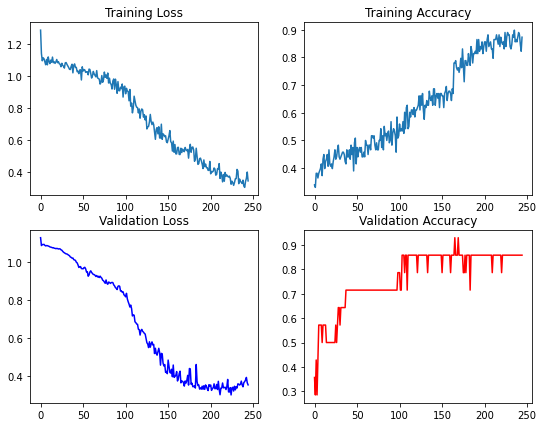

In [565]:
plt.figure(figsize = (9,7))
plt.subplot(221)
plt.title('Training Loss')
plt.plot(loss)

plt.subplot(222)
plt.title('Training Accuracy')
plt.plot(acc)

plt.subplot(223)
plt.title('Validation Loss')
plt.plot(val_loss, color = 'blue')

plt.subplot(224)
plt.title('Validation Accuracy')
plt.plot(val_acc, color = 'red')

plt.show()

(44, 3)
(44, 3)
accuracy = 0.89


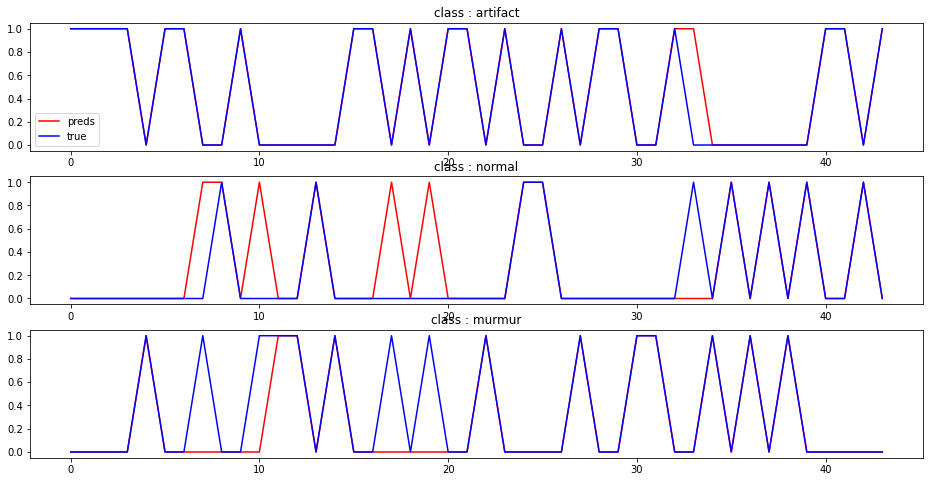

In [566]:
preds = tf.argmax(model.predict(x_test), 1)
labels = tf.argmax(y_test, 1)

accuracy_op = tf.keras.metrics.Accuracy()
test_acc = accuracy_op(preds, labels).numpy()

result = pd.get_dummies(preds).values

print(result.shape)
print(y_test.shape)

plt.figure(figsize = (16,8))
print(f"accuracy = {test_acc:.2f}")
for i in range(3) : 
  plt.subplot(3, 1, i+1)
  plt.plot(result[:,i], c = 'r')
  plt.plot(y_test[:,i], c = 'b')
  plt.title(f"class : {CLASSES[i]}")
  if i == 0 : 
    plt.legend(['preds', 'true'])

In [568]:
print(model.predict(x_test))
print(preds)

[[1.00000000e+00 4.45254820e-08 7.11778192e-09]
 [9.99629974e-01 3.15833255e-04 5.42387497e-05]
 [9.99997735e-01 2.07653761e-06 2.79431475e-07]
 [9.99988198e-01 9.22254912e-06 2.56734302e-06]
 [8.16899687e-02 3.51618409e-01 5.66691518e-01]
 [9.99920845e-01 4.41433804e-05 3.50403170e-05]
 [9.99281347e-01 5.36055071e-04 1.82572374e-04]
 [8.19328427e-02 5.69097638e-01 3.48969489e-01]
 [7.75924399e-02 5.15784144e-01 4.06623393e-01]
 [9.99999881e-01 6.84181742e-08 2.66699507e-09]
 [4.81045972e-05 9.99916196e-01 3.55854390e-05]
 [9.01553035e-02 4.23119664e-01 4.86725062e-01]
 [7.38936737e-02 4.50680703e-01 4.75425661e-01]
 [6.56992523e-03 9.78865623e-01 1.45645384e-02]
 [8.16899687e-02 3.51618409e-01 5.66691518e-01]
 [9.99995112e-01 4.42230748e-06 4.51719728e-07]
 [9.93833542e-01 3.41216428e-03 2.75428989e-03]
 [8.92669782e-02 5.05701482e-01 4.05031562e-01]
 [9.99999881e-01 1.35956839e-07 1.08308411e-08]
 [2.46903626e-03 9.88313675e-01 9.21719242e-03]
 [9.93268907e-01 5.54326456e-03 1.187838

the number of mis-prediction : 5


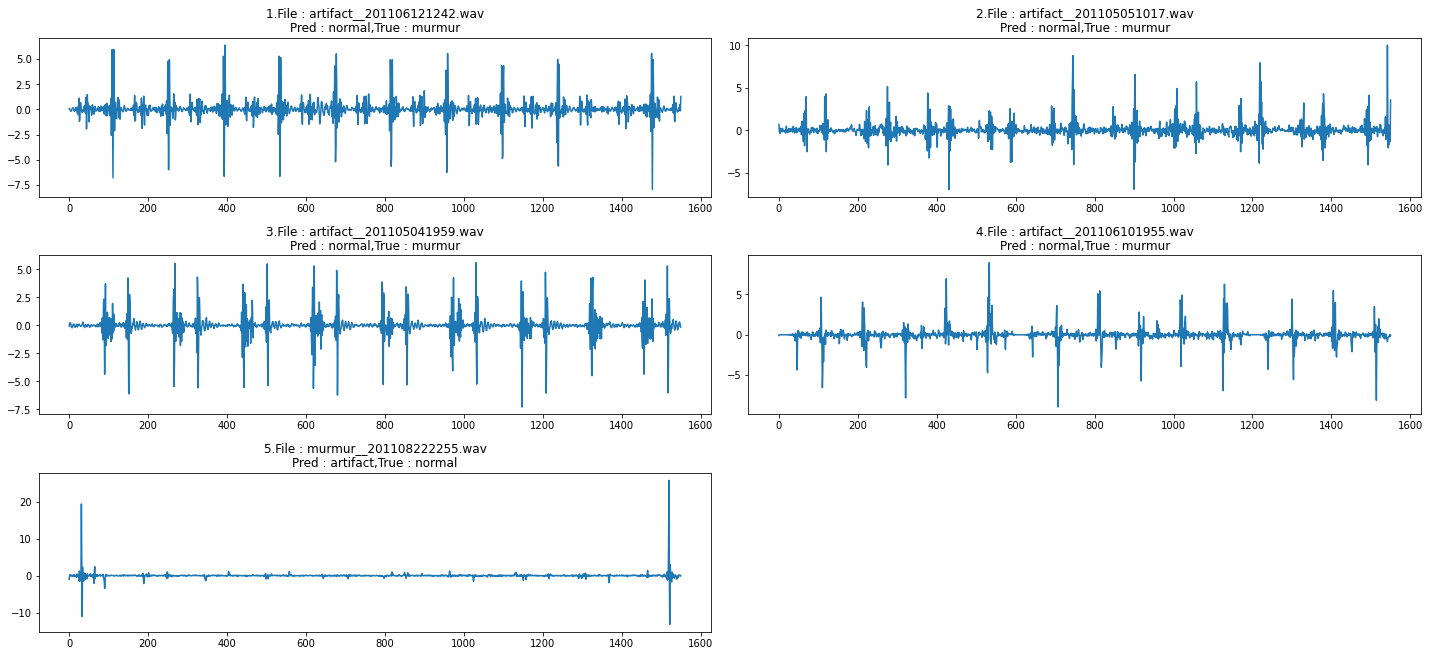

In [569]:
mis_preds = [i for i in range(len(labels)) if (preds[i].numpy() != labels[i].numpy())]
num = len(mis_preds)
print(f"the number of mis-prediction : {num}")

row = 4
col = int(np.ceil(num/row))

fig = plt.figure(figsize = (20, 12))

for i in range(num) : 
  plt.subplot(row, col, i+1)
  plt.plot(x_test[mis_preds[i]])
  plt.title(f"{i+1}.File : {test_filenames[i]}\n"
            f"Pred : {CLASSES[preds[mis_preds[i]]]},"
            f"True : {CLASSES[labels[mis_preds[i]]]}")
  
fig.tight_layout()